In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import pyfeng as pf

from yabte.backtest import (
    Asset,
    Strategy,
    StrategyRunner,
    PositionalOrder,
    OrderSizeType,
    Book,
    CashTransaction,
)
from yabte.utilities.simulation.geometric_brownian_motion import gbm_simulate_paths

In [2]:
# TODO: track call premium mtm valuation using constant / stochastic volatility


class DeltaHedgingStrat(Strategy):
    def init(self):
        # flag to determine if hedging started
        self.in_hedge = False

        # capture some data for analysis
        self.metrics = defaultdict(dict)

    def on_open(self):
        data = self.data
        p = self.params
        ts = self.ts
        book = self.books["Main"]
        t = (p.exp - self.ts).days / 100

        s = data.ACME.Open[-1]

        if not self.in_hedge:
            # buy option on t0
            self.bsm_call_option = pf.Bsm(sigma=vol, intr=r, divr=0)
            prem = self.bsm_call_option.price(p.K, s, t)
            # book.add_transactions([CashTransaction(ts=self.ts, total=round(Decimal(-prem), 2), desc="option premium")])
            self.in_hedge = True

        # buy delta hedge shares
        delta = self.bsm_call_option.delta(p.K, s, t)
        self.orders.append(
            PositionalOrder(
                asset_name="ACME", size=-1 * delta, size_type=OrderSizeType.QUANTITY
            )
        )

        gamma = self.bsm_call_option.gamma(p.K, s, t)
        self.metrics[ts]["delta"] = delta
        self.metrics[ts]["gamma"] = gamma


assets = [Asset(name="ACME", denom="USD", quantity_round_dp=6)]

# gbm params
r = 0.05
vol = 0.2
s0 = 100
N = 101
T = N / 365

# simulate data
rng = np.random.default_rng(12345)  # for reproducibility
ix = pd.date_range(end="20221231", periods=N, freq="D")
p = gbm_simulate_paths(
    mu=r, sigma=vol, R=1, T=T, n_steps=N, n_sims=len(assets), rng=rng
)
df = pd.DataFrame(s0 * np.c_[p[:, :, 0], p[:, :, 0]], index=ix)
df.columns = pd.MultiIndex.from_tuples((("ACME", "Open"), ("ACME", "Close")))

# run simulation
book = Book(name="Main", cash="0", rate=0.05 / 100)
sr = StrategyRunner(
    data=df,
    assets=assets,
    strat_classes=[DeltaHedgingStrat],
    strat_params={
        "r": r,
        "vol": vol,
        "exp": ix[-1],
        "K": s0,
    },
    books=[book],
)
sr.run()

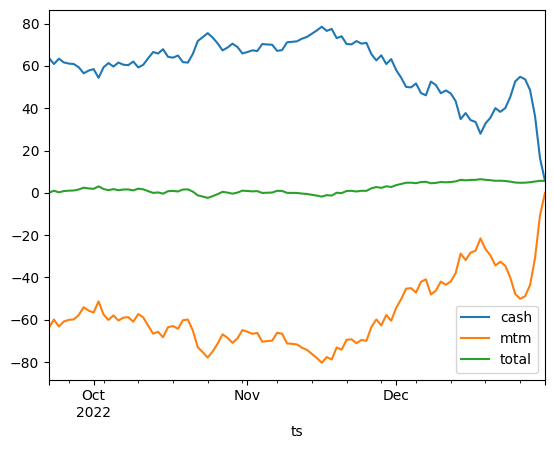

In [3]:
sr.book_history.Main.plot();

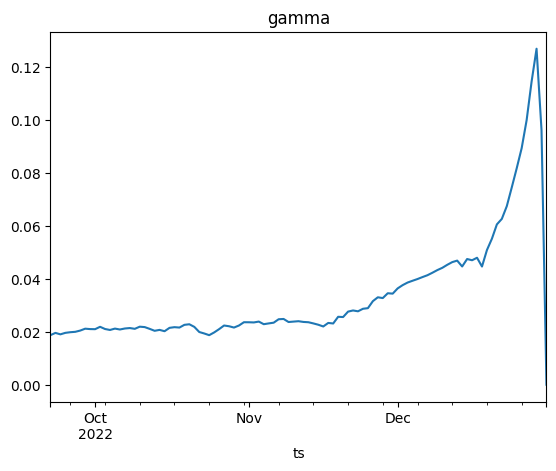

In [4]:
metrics = pd.DataFrame.from_dict(sr.strategies[0].metrics, orient="index").reindex(
    sr.book_history.index
)
metrics.gamma.plot(title="gamma");

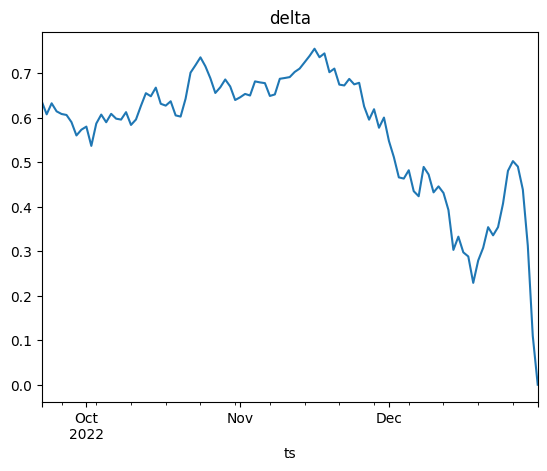

In [5]:
metrics.delta.plot(title="delta");

In [6]:
# total heding cost
sr.transaction_history.total.sum()

Decimal('5.63735976')

In [7]:
with pd.option_context("display.max_rows", None):
    display(sr.transaction_history)

,ts,total,desc,quantity,price,asset_name,book
0,2022-09-22,63.68310000,sell ACME,-0.636831,100.00,ACME,Main
1,2022-09-22,0.032,interest payment on cash 63.68,NaN,NaN,NaN,Main
2,2022-09-23,-62.74059012,buy ACME,0.636831,98.52,ACME,Main
3,2022-09-23,59.87119512,sell ACME,-0.607706,98.52,ACME,Main
4,2022-09-23,0.030,interest payment on cash 60.85,NaN,NaN,NaN,Main
5,2022-09-24,-60.67336704,buy ACME,0.607706,99.84,ACME,Main
6,2022-09-24,63.14690304,sell ACME,-0.632481,99.84,ACME,Main
7,2022-09-24,0.032,interest payment on cash 63.35,NaN,NaN,NaN,Main
8,2022-09-25,-62.57767014,buy ACME,0.632481,98.94,ACME,Main
9,2022-09-25,60.78715296,sell ACME,-0.614384,98.94,ACME,Main
